In [1]:
from time import time
from enum import Enum

import nest_asyncio
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

from keras.layers import Flatten, Dense, Dropout, Conv2D, \
    MaxPool2D
from keras.models import Sequential

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


2024-06-11 15:50:36.695995: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 15:50:37.221579: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 15:50:38.781429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 15:50:41.154738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0

In [2]:
EXPERIMENT_NAME = "DOH-Exfiltration-detection"
this_dir = Path.cwd()
print(this_dir)

/home/bkcs/Documents/doh/doh-exfiltration-detector


# Load data

In [3]:

data_dir = this_dir / "dataset"


class Label(Enum):
    BENIGN = 0
    DNSCAT2 = 1
    DNS2TCP = 2
    IODINE = 3


NROWS = 10000

# Đọc file CSV benign
benign_dir = data_dir / "benign"

benign_data = pd.read_csv(benign_dir / "benign_chrome_adguard.csv", nrows=NROWS)
benign_data['label'] = Label.BENIGN.value

# Đọc các file CSV khác
malicious_dir = data_dir / "malicious"

dnscat2_data = pd.read_csv(malicious_dir / "dnscat2.csv", nrows=NROWS)
dnscat2_data['label'] = Label.DNSCAT2.value
dns2tcp_data = pd.read_csv(malicious_dir / "dns2tcp.csv", nrows=NROWS)
dns2tcp_data['label'] = Label.DNS2TCP.value
iodine_data = pd.read_csv(malicious_dir / "iodine.csv", nrows=NROWS)
iodine_data['label'] = Label.IODINE.value

print('benign_data: ' + str(benign_data.groupby('flow_id').size().count()),
      ', dnscat2_data: ' + str(dnscat2_data.groupby('flow_id').size().count()),
      ', dns2tcp_data: ' + str(dns2tcp_data.groupby('flow_id').size().count()),
      ', iodine_data: ' + str(iodine_data.groupby('flow_id').size().count()))

benign_data: 1000 , dnscat2_data: 1000 , dns2tcp_data: 1000 , iodine_data: 1000


# Split data into 64% train, 16% validate and 20% test

In [4]:
from sklearn.model_selection import GroupShuffleSplit


def split(dataset: pd.DataFrame, split_ratio: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split a dataset into a training and test dataset.
    :param dataset: The dataset to split.
    :param split_ratio: The ratio of the split.
    :return: A tuple containing the training and test datasets.
    """
    first_inds, next_inds = next(
        GroupShuffleSplit(train_size=split_ratio, n_splits=2, random_state=42).split(dataset,
                                                                                     groups=dataset['flow_id']))

    return dataset.iloc[first_inds], dataset.iloc[next_inds]

In [5]:
# # Split data into train, validate and test with group flow_id
# def slit_train_validate_test(data, train_percent=.8, validate_percent=.2, seed=None):
#     np.random.seed(seed)
#     grouped = data.groupby('flow_id')
#     arranged = np.arange(grouped.ngroups)
#     np.random.shuffle(arranged)
# 
#     train = data[grouped.ngroup().isin(arranged[:int(len(arranged) * train_percent)])]
#     test = data.drop(train.index)
#     test.reset_index(drop=True, inplace=True)
# 
#     grouped = train.groupby('flow_id')
#     arranged = np.arange(grouped.ngroups)
#     np.random.shuffle(arranged)
# 
#     temp = train[grouped.ngroup().isin(arranged[:int(len(arranged) * (1 - validate_percent))])]
#     validate = train.drop(temp.index)
#     validate.reset_index(drop=True, inplace=True)
#     train = temp
# 
#     return train, validate, test

In [6]:
# Split benign data into train, validate and test
train_benign, test_benign = split(benign_data, 0.8)
train_benign, validate_benign = split(train_benign, 0.8)

In [7]:
# Split dnscat2 data into train, validate and test
# train_dnscat2, validate_dnscat2, test_dnscat2 = slit_train_validate_test(dnscat2_data)
# print("train_dnscat2: ", train_dnscat2.groupby('flow_id').size().count(), ", validate_dnscat2: ",
#       validate_dnscat2.groupby('flow_id').size().count(), ", test_dnscat2: ",
#       test_dnscat2.groupby('flow_id').size().count())

In [8]:
train_dnscat2, test_dnscat2 = split(dnscat2_data, 0.8)
train_dnscat2, validate_dnscat2 = split(train_dnscat2, 0.8)

In [9]:
# Split dns2tcp data into train, validate and test
train_dns2tcp, test_dns2tcp = split(dns2tcp_data, 0.8)
train_dns2tcp, validate_dns2tcp = split(train_dns2tcp, 0.8)

In [10]:
# Split iodine data into train, validate and test
train_iodine, test_iodine = split(iodine_data, 0.8)
train_iodine, validate_iodine = split(train_iodine, 0.8)

# Merge data

In [11]:
# # Merge data from all iterations in data list, reset flow id by increasing the last flow id of the previous data
# def merge_dataframes(dataframes: list):
#     flow_id = 1
#     merged_dataframes = []
# 
#     for df in dataframes:
#         df.reset_index(drop=True, inplace=True)
#         # Change all item flow_id of this flow to new flow_id
#         for flow in df.groupby('flow_id'):
#             flow[1]['flow_id'] = flow_id
#             merged_dataframes.append(flow[1])
#             flow_id += 1
# 
#     return pd.concat(merged_dataframes)

In [12]:
# data_train = merge_dataframes([train_benign, train_dnscat2, train_dns2tcp, train_iodine])
# data_validate = merge_dataframes([validate_benign, validate_dnscat2, validate_dns2tcp, validate_iodine])
# data_test = merge_dataframes([test_benign, test_dnscat2, test_dns2tcp, test_iodine])
# print("Train data: " + str(data_train.groupby('flow_id').size().count()),
#       ", Validate data: " + str(data_validate.groupby('flow_id').size().count()),
#       ", Test data: " + str(data_test.groupby('flow_id').size().count()))

In [13]:
data_train = pd.concat([train_benign, train_dnscat2, train_dns2tcp, train_iodine], ignore_index=True, sort=False,
                       axis=0)
data_validate = pd.concat([validate_benign, validate_dnscat2, validate_dns2tcp, validate_iodine], ignore_index=True,
                          sort=False, axis=0)
data_test = pd.concat([test_benign, test_dnscat2, test_dns2tcp, test_iodine], ignore_index=True, sort=False, axis=0)

# Get label

In [14]:
def most_frequent(flow):
    return max(set(flow), key=flow.count)

In [15]:
def get_label(data):
    grouped = data.groupby('flow_id')['label'].apply(list).to_dict()

    label = []
    for flow in grouped:
        label.append(most_frequent(grouped[flow]))

    return np.array(label)

In [16]:
label_train = np.array(get_label(data_train))
label_validate = np.array(get_label(data_validate))
label_test = np.array(get_label(data_test))

print('Label train: ', len(label_train), ', Label validate: ', len(label_validate), ', Label test: ', len(label_test))

Label train:  2560 , Label validate:  640 , Label test:  800


In [17]:
data_train_without_flow = data_train.drop('flow_id', axis=1)
data_validate_without_flow = data_validate.drop('flow_id', axis=1)
data_test_without_flow = data_test.drop('flow_id', axis=1)

In [18]:
NUM_FEATURE = len(data_test_without_flow.columns) - 1
NUM_CLASSES = len(np.unique(data_test_without_flow['label']))
NUM_PACKETS_PER_FLOW = 10

print('Number of features: ', NUM_FEATURE, ', Number of classes: ', NUM_CLASSES, ', Number of packets per flow: ',
      NUM_PACKETS_PER_FLOW)

Number of features:  512 , Number of classes:  4 , Number of packets per flow:  10


In [19]:
x_train = np.array(
    (data_train_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE))
x_validate = np.expand_dims(
    (data_validate_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE),
    axis=-1)
x_test = np.expand_dims(
    (data_test_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE),
    axis=-1)

print('x_train shape: ', x_train.shape, ', x_validate shape: ', x_validate.shape, ', x_test shape: ', x_test.shape)

x_train shape:  (2560, 10, 512) , x_validate shape:  (640, 10, 512, 1) , x_test shape:  (800, 10, 512, 1)


# Model training

In [20]:
def create_keras_model(num_packet_per_flow, num_features, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(num_packet_per_flow, num_features, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    return model

In [21]:
# Initialize the model
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 4

model = create_keras_model(NUM_PACKETS_PER_FLOW, NUM_FEATURE, NUM_CLASSES)
model.summary()

/home/bkcs/Documents/doh/doh-exfiltration-detector/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 512, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 512, 32)    │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 256, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 256, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 256, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 256, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,476 (16.32 MB)

 Trainable params: 4,277,476 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'])
start = time()

history = model.fit(x_train, label_train, epochs=5, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(x_validate, label_validate))
end = time() - start

print(f'Training time: {end} seconds')

Epoch 1/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 54s 82ms/step - loss: 0.9263 - sparse_categorical_accuracy: 0.5613 - val_loss: 0.4896 - val_sparse_categorical_accuracy: 0.7906
Epoch 2/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - loss: 0.4432 - sparse_categorical_accuracy: 0.8293 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.8969
Epoch 3/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - loss: 0.3285 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.2288 - val_sparse_categorical_accuracy: 0.9422
Epoch 4/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.9155 - val_loss: 0.1828 - val_sparse_categorical_accuracy: 0.9438
Epoch 5/5
640/640 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9382 - val_loss: 0.1594 - val_sparse_categorical_accuracy: 0.9516
Training time: 263.5723464488983 seconds


# Evaluate the model

In [23]:
import os

result_dir = this_dir / 'results'
output_dir = result_dir / EXPERIMENT_NAME

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [24]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]
_, test_acc = model.evaluate(x_test, label_test, verbose=2, batch_size=BATCH_SIZE)
train_val = str(round(best_model_accuracy * 100)) + "_" + str(round(test_acc * 100))

print(train_val)

200/200 - 2s - 9ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.9538
94_95


In [25]:
import keras

keras.saving.save_model(model, output_dir / 'model.keras')

In [26]:
with open(output_dir / 'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [27]:
def sec_to_hours(seconds):
    a = seconds // 3600
    b = (seconds % 3600) // 60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


total_time = "Time: {}".format(sec_to_hours(end))

text_file = open(output_dir / "time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [28]:
start = time()
predictions = model.predict(
    x_test, verbose=2, batch_size=BATCH_SIZE)
end = time() - start
text_file = open(output_dir / "time.txt", "a")
text_file.write(f'\nPredict time: {sec_to_hours(end)}')
text_file.close()

200/200 - 2s - 9ms/step


In [29]:
flow_pred = np.argmax(predictions, axis=-1)

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

CLASSES_LIST = ['Benign', 'DNSCat2', 'DNS2TCP', 'Iodine']

with open(output_dir / 'metrics.txt', 'w') as f:
    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(label_test, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(label_test, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(label_test, flow_pred, target_names=CLASSES_LIST), file=f)
    f.close()


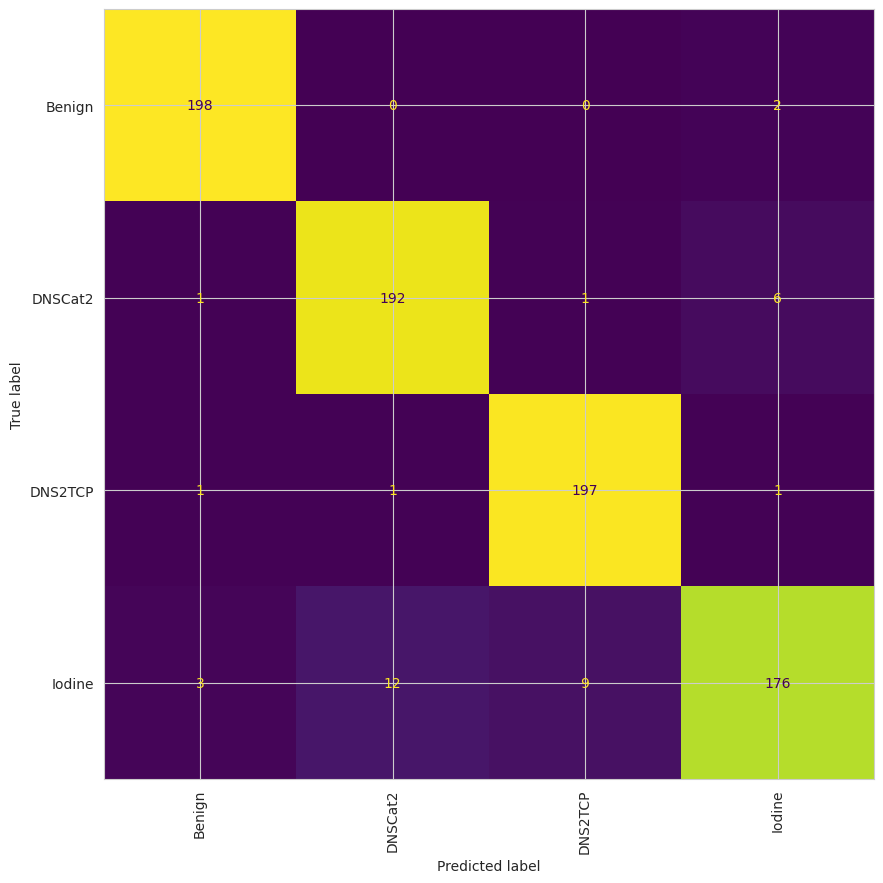

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(label_test, flow_pred, display_labels=CLASSES_LIST, xticks_rotation='vertical',
                                        ax=ax, colorbar=False)
plt.savefig(output_dir / 'ConfusionMatrix.pdf', bbox_inches="tight")

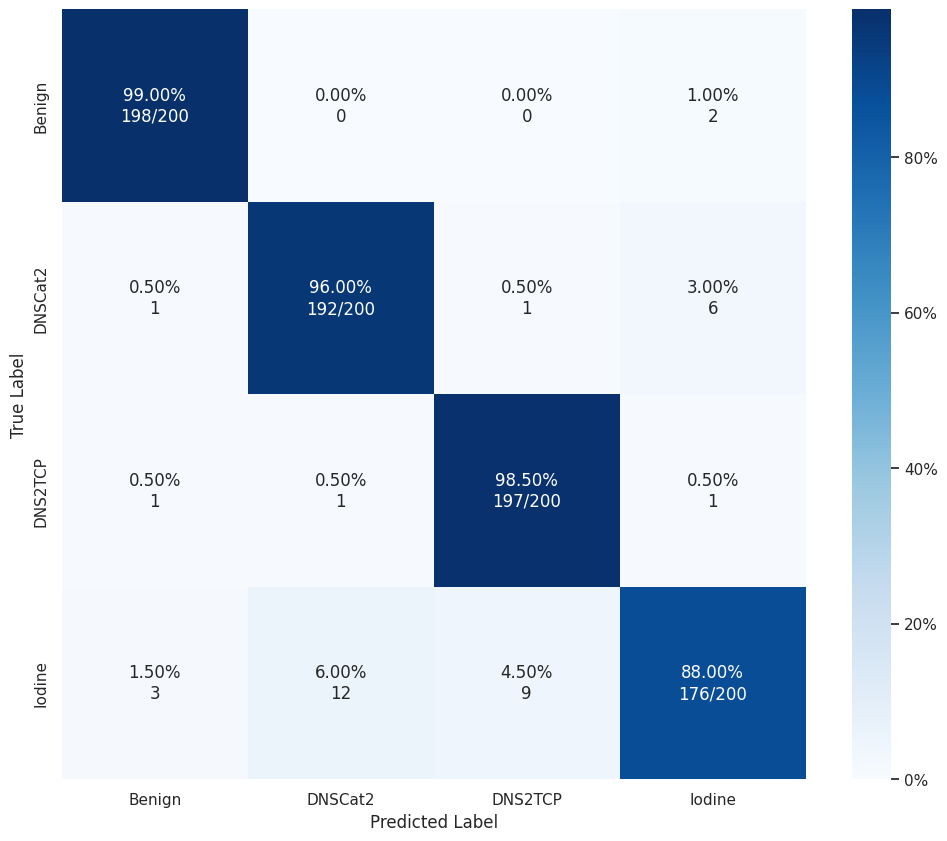

In [32]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17, 17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s[0])
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format': PercentFormatter()},
                yticklabels=classes, cmap="Blues")
    plt.savefig(filename, bbox_inches='tight')


cm_analysis(y_true=label_test, y_pred=flow_pred, filename=output_dir / 'ConfusionMatrix_nom.pdf', labels=[0, 1, 2, 3],
            classes=CLASSES_LIST, figsize=(12, 10))

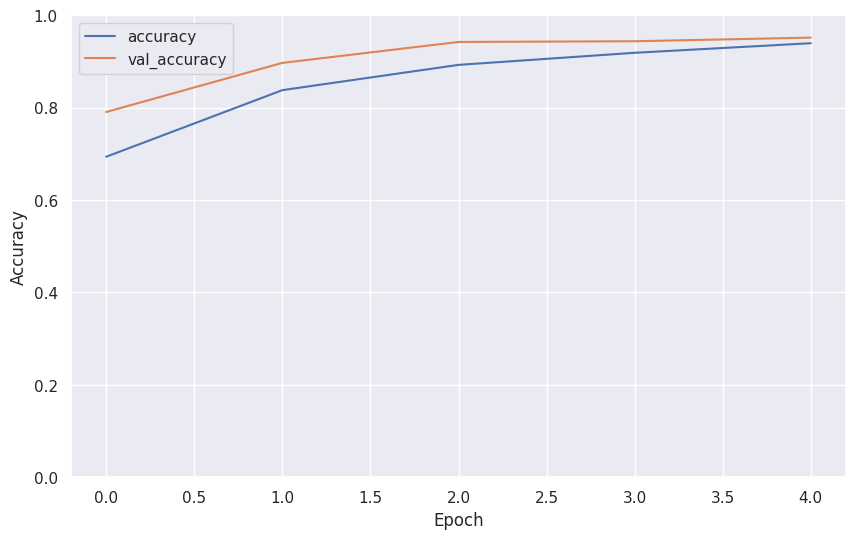

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(
    history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.savefig(output_dir / "normal_model_Accuracy.pdf")

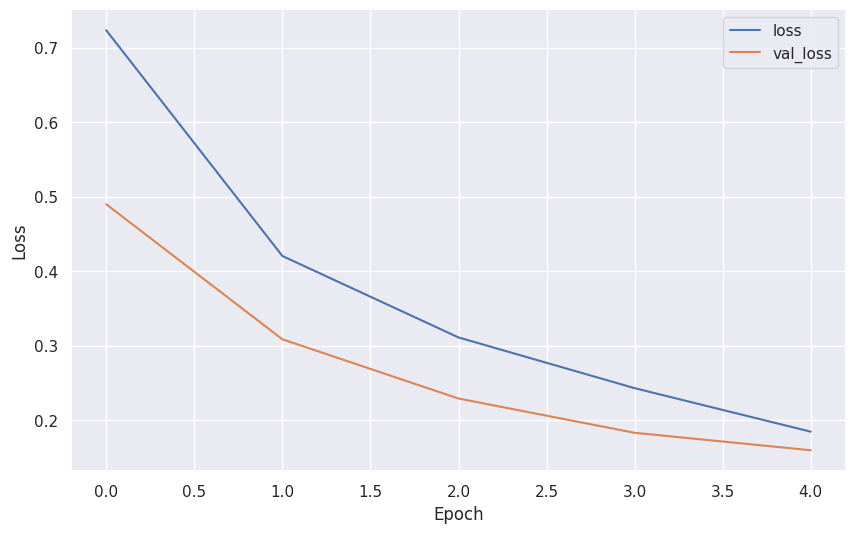

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(output_dir / "normal_model_Loss.pdf")
